# Выявление негативных комментариев с BERT

## Описание проекта

Интернет-магазин запускает новый сервис — пользователи сами могут редактировать и дополнять описания товаров, как в вики-сообществах.  Поэтому магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача — на основе набора  данных с разметкой о токсичности правок обучить модель классифицировать комментарии на позитивные и негативные. По условию значение метрики качества *F1* должно быть не меньше 0.75. 

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import transformers 
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
##%matplotlib inline

from tqdm import notebook
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score


from pymystem3 import Mystem
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk import word_tokenize
from PIL import Image
import nltk

In [2]:
pth1 = 'C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/16_toxic_comments/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=0)
else:
    print('Oops!')

In [3]:
display(df.sample(5))
df.info()

,text,toxic
19178,"""\nI'm currently converting the article into a...",0
94288,I don’t believe I have met you before? Can you...,0
60367,Cambridge geonotices \n\nThanks for putting th...,0
139301,"""\n\nMediation\nYou may interested in this med...",0
117718,"""\n\nIn the mean time, I guess I've a got a so...",1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Согласно документации к данным, cтолбец `text` содержит текст комментария, а `toxic` — целевой признак.

Посмотрим, какие слова чаще всего встречаются в токсичных и нетоксичных твитах. Для этого определим несколько функций:

In [5]:
def remove_chars_from_text(text, chars):  # убираем из текста пунктуацию
    return "".join([ch for ch in text if ch not in chars])

In [6]:
def text_cleanup(text):     # убираем стоп-слова из текста    
    stopset = set(stop_words)
    cleanup = " ".join(filter(lambda word: word not in stopset, text.split()))
    return cleanup

In [7]:
def make_fdist(n):
    if (n == 1) or (n == 0):
        corpus = df.loc[df['toxic'] == n, 'text'].values.astype('U')  
        text = ' '.join(corpus)
        text = text.lower()
        text = remove_chars_from_text(text, spec_chars)
        text = remove_chars_from_text(text, string.digits)
        text_cleaned = text_cleanup(text)
        tokens = word_tokenize(text_cleaned)
        text_cleaned = nltk.Text(tokens)    
        if n == 0:
            colormap='summer'
            color='darkgreen'
            title='Самые частые слова в нетоксичных твитах'
            
        else: 
            colormap = 'autumn'
            color='crimson'
            title='Самые частые слова в токсичных твитах'
        fdist = FreqDist(text_cleaned) 
        fdist.plot(15, cumulative=False, color=color)
        text_raw = " ".join(text_cleaned)    
        wordcloud = WordCloud(width=1400, 
                      height=1000, 
                      max_words=150, 
                      colormap=colormap, 
                      background_color ='white', 
                      collocations=False).generate(text_raw)
        plt.figure(figsize=(8,6))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title);
    else: print('put 1 or 0')    

Определим наборы спецсимволов и стоп-слов для удаления:

In [8]:
spec_chars = string.punctuation + '\n\xa0' 
stop_words = stopwords.words('english')
stop_words.extend(['u', 'im', 'dont' ])

Выведем график часто встречающихся слов для нетоксичных твитов:

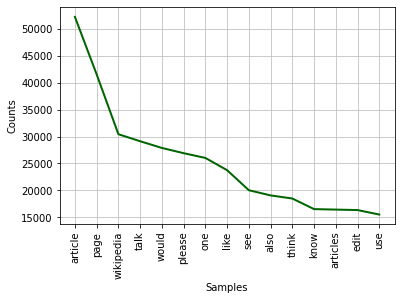

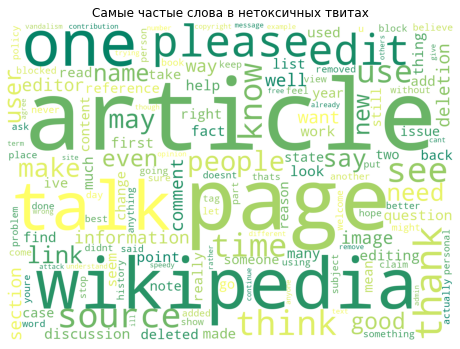

In [9]:
make_fdist(0)

А теперь для токсичных:

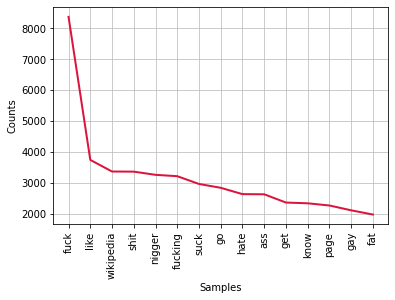

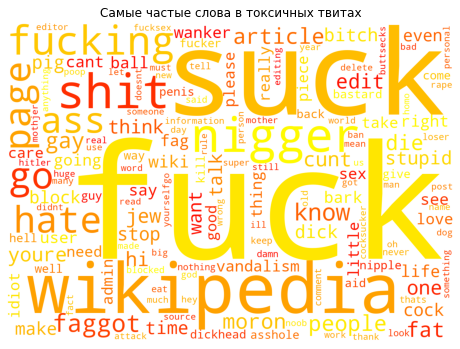

In [10]:
make_fdist(1)

Общего у этих наборов слов немного, но кое что есть -  и это слово "википедия".

<div class="alert alert-info">
<font size="5"><b>Комментарий студента 🐣 </b></font> 
    
Получился довольно милый принт на футболку 👀

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Оценил твой юмор ) Кстати можно на передней части футболки выложить позитивные, а на обратный частые слова из негативных твитов. Ты сказать Лицевая и Оборотная сторона индивида ) Но Википедия это общее!




</div>


## Подготовка данных

Т.к для bert датафрейм достаточно большой, возьмем 2000 случайных строк, чтобы обучение не было слишком долгим. Посмотрим на баланс классов:

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<AxesSubplot:>

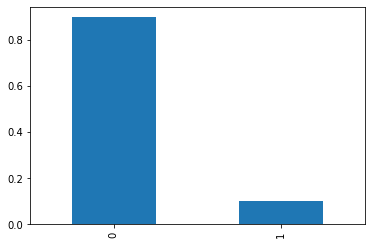

In [11]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

In [12]:
df = df.sample(3000).reset_index(drop=True)
df.shape

(3000, 2)

Посмотрим на баланс классов в полученной выборке:

0    0.902333
1    0.097667
Name: toxic, dtype: float64


<AxesSubplot:>

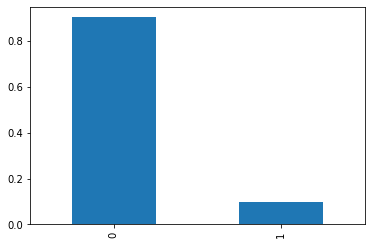

In [13]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

## BERT 

### Подготовка текстов

Инициализируем токенизатор и преобразуем текст в номера токенов из словаря:

In [14]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

In [15]:
df['tokenized'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


In [16]:
df = df.dropna()
df= df.reset_index(drop=True)

Видим такое сообщение:


`Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors`


Поэтому будем использовать только векторы с длиной до 512, чтобы избежать ошибок.

In [17]:
MAX_LEN = 512
tokenized_proper = []                   # создаем пустой спиок для сохранения подходящих векторов
target = []                             # и список для соответствующих значений из df['toxic']

for i in range(df.shape[0]):
    if len(df['tokenized'][i]) <= MAX_LEN:
        tokenized_proper.append(df['tokenized'][i])
        target.append(df['toxic'][i])

In [18]:
tokenized_proper = pd.Series(tokenized_proper)
target = pd.Series(target)

Применим метод padding, чтобы уравнять длины всех векторов, а также определим attention_mask, которая покажет модели, что нули не несут значимой информации:

In [19]:
padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in tokenized_proper])
attention_mask = np.where(padded != 0, 1, 0) 

Инициализируем модель:

In [20]:
bert_model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Преобразуем токенизированные тексты в эмбеддинги:

In [21]:
%%time

batch_size = 300
embeddings = []
for i in notebook.tqdm(range((padded.shape[0] // batch_size)+1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 4h 27min 19s
Wall time: 38min 31s


In [22]:
features = np.concatenate(embeddings)

print(features.shape)
print(target.shape)

(2927, 768)
(2927,)


## Обучение

Разделим датасет на обучающую и тестовую выборки:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                   stratify=target)
print(X_train.shape)
print(X_test.shape)

(2341, 768)
(586, 768)


Определим функцию для поиска лучшего значения F1:

In [24]:
def best_f1(model, params):
    grid = GridSearchCV(model, params, scoring='f1') 
    grid.fit(X_train, y_train)
    f1 = grid.best_score_
    print('F1-мера на обучающей выборке:', round(f1, 3))
    return f1, grid.best_estimator_

### Логистическая регрессия

In [29]:
params = {}

f1_lr, model_lr = best_f1(LogisticRegression(random_state=42, solver='liblinear'), params)

F1-мера на обучающей выборке: 0.926


### Дерево решений

In [30]:
params = {'max_depth': range (1, 7),
          'min_samples_split': range (2, 7),
          'min_samples_leaf' : range(2, 7) }


f1_dt, model_dt = best_f1(DecisionTreeClassifier(random_state=42), params)

F1-мера на обучающей выборке: 0.909


### Случайный лес

In [31]:
params = {'n_estimators': range (1, 7),
              'max_depth': range (1, 7),
              'min_samples_split': range (2, 7),
              'min_samples_leaf' : range(2, 7)
              }


f1_rf, model_rf = best_f1(RandomForestClassifier(random_state=42), params)

F1-мера на обучающей выборке: 0.939


### CatBoost

In [32]:
params = {}

f1_cb, model_cb = best_f1(CatBoostClassifier(verbose=False, iterations=300,learning_rate=0.001, random_state=42), params)

F1-мера на обучающей выборке: 0.93


Объединим результаты в одну таблицу: 

In [33]:
results = pd.DataFrame([
    [f1_lr],
    [f1_dt],
    [f1_rf],
    [f1_cb]], 
    columns=['F1'],
    index=['LogisticRegression', 'DecisionTree', 'RandomForest', 'CatBoost'])
results.sort_values(by='F1', ascending=False)

,F1
RandomForest,0.939074
CatBoost,0.929840
LogisticRegression,0.925839
DecisionTree,0.909187


Лучшие результаты на обучающей выборке показали модели RandomForest - 0.939 и СatBoost - 0.929, далее проверим их на тестовой выборке:

In [34]:
pred_test = model_rf.predict(X_test)
print('F1-мера на тестовой выборке:', round(f1_score(y_test, pred_test), 3))

F1-мера на тестовой выборке: 0.924


In [35]:
pred_test = model_cb.predict(X_test)
print('F1-мера на тестовой выборке:', round(f1_score(y_test, pred_test), 3))

F1-мера на тестовой выборке: 0.957


Полученное на тестовой выборке с помощью CatBoost выше, чем у RandomForest - 0.957, значение превышает заданное заказчиком в 0.75.

## Выводы

Задача была выполнена с помощью предобученной модели BERT(toxic-bert). Наилучшей моделью для выполнения является модель RandomForest, со значением F1-меры в 0.90, что превышает заданное значение в 0.75.

В ходе работы были выполнены следующие шаги:

 - Загрузка и чтение данные;

 - Провели частотный анализ текста - построили график и облако слов для наиболее встречающихся слов в текстах;
 
 - Преобразовали тексты при помощи предобученной модели BERT(toxic-bert);

 - Обучили различные модели; 
 
 - Построили таблицу со значениями метрики для каждой модели;
 
 - Выбрали лучшую модель.